# Tutorial 2: Jeans Modeling with Osipkov-Merritt Anisotropy

In this tutorial, we extend our Jeans modeling framework to use the **Osipkov-Merritt (OM) anisotropy profile**, which describes a system that transitions from isotropic orbits in the center to radially-biased orbits in the outskirts.

You should have completed `01_constant_beta.ipynb` before starting this tutorial.

In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as units
import astropy.constants as constants

%matplotlib inline

# Loading the data

We will use a different mock dataset that was generated with Osipkov-Merritt anisotropy.

In [2]:
data = pd.read_csv('AST1420_mock_verr5/CoreOM.csv')
data

,x_kpc,y_kpc,z_kpc,vx_kms,vy_kms,vz_kms,err_vx_kms,err_vy_kms,err_vz_kms,vx_true_kms,vy_true_kms,vz_true_kms
0,-0.170771,-0.094590,0.161265,-16.602806,-15.381287,-12.855552,5.0,5.0,5.0,-13.297748,-17.781906,-4.978763
1,-0.009203,-0.199989,-0.761633,8.727065,2.405653,32.292346,5.0,5.0,5.0,5.001732,7.657331,30.668958
2,0.296776,-0.441920,0.240205,9.262202,6.745085,-13.481733,5.0,5.0,5.0,7.597660,9.094570,-15.821786
3,-0.072608,-0.077360,-0.034210,-5.022099,4.055740,18.398872,5.0,5.0,5.0,-0.506949,4.229602,20.215356
4,0.081618,0.167619,0.107903,-2.388102,-6.385184,-22.792597,5.0,5.0,5.0,0.248239,-5.198396,-15.991179
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.065849,0.018987,-0.030799,14.795632,0.892057,-12.573354,5.0,5.0,5.0,13.921373,0.885789,-3.690528
96,-0.018171,0.238443,-0.107853,-4.220373,1.734273,-1.771937,5.0,5.0,5.0,-0.713833,-0.422970,5.982723
97,-0.280050,0.177228,-0.014635,-31.850972,11.682740,-9.221124,5.0,5.0,5.0,-31.328221,20.010659,-7.275823
98,0.016639,-0.125942,0.354580,-10.285387,3.915109,-2.151548,5.0,5.0,5.0,2.505732,3.519220,-1.695135


In [3]:
true_parameters = pd.read_csv('AST1420_mock_verr5/true_parameters.csv')
true_parameters = true_parameters[true_parameters['Model'] == 'CoreOM']
true_parameters

,Model,DM_Profile,Anisotropy,r_half_kpc,r_a_kpc,gamma,rho_dm,r_dm,beta0
0,CoreOM,Core,Osipkov-Merritt,0.25,0.25,0.0,400000000.0,1.0,0.0


In [4]:
import utils

In [5]:
R_proj = np.sqrt(data['x_kpc']**2 + data['y_kpc']**2).values
vlos = data['vz_kms'].values
vlos_err = data['err_vz_kms'].values
vlos_true = data['vz_true_kms'].values

# calculate the binned velocity dispersion
vdisp_binned_res = utils.calc_vdisp_los_binned(
    R_proj, vlos, vlos_err,
    ntracer_per_bin=50,
)

100%|██████████| 2000/2000 [00:00<00:00, 4481.34it/s]


Autocorrelation times: [34.02594908 27.50033407]
Mean tau: 30.8 steps (total chain: 2000 steps)
Discarded 102 steps, thinned by 13
Final sample size: 1168


100%|██████████| 2000/2000 [00:00<00:00, 4527.08it/s]


Autocorrelation times: [25.07506201 29.10096139]
Mean tau: 27.1 steps (total chain: 2000 steps)
Discarded 87 steps, thinned by 12
Final sample size: 1272


100%|██████████| 2000/2000 [00:00<00:00, 4541.31it/s]


Autocorrelation times: [28.87969825 23.95978245]
Mean tau: 26.4 steps (total chain: 2000 steps)
Discarded 86 steps, thinned by 11
Final sample size: 1392


100%|██████████| 2000/2000 [00:00<00:00, 4569.37it/s]

Autocorrelation times: [19.06006077 25.76271681]
Mean tau: 22.4 steps (total chain: 2000 steps)
Discarded 77 steps, thinned by 9
Final sample size: 1704


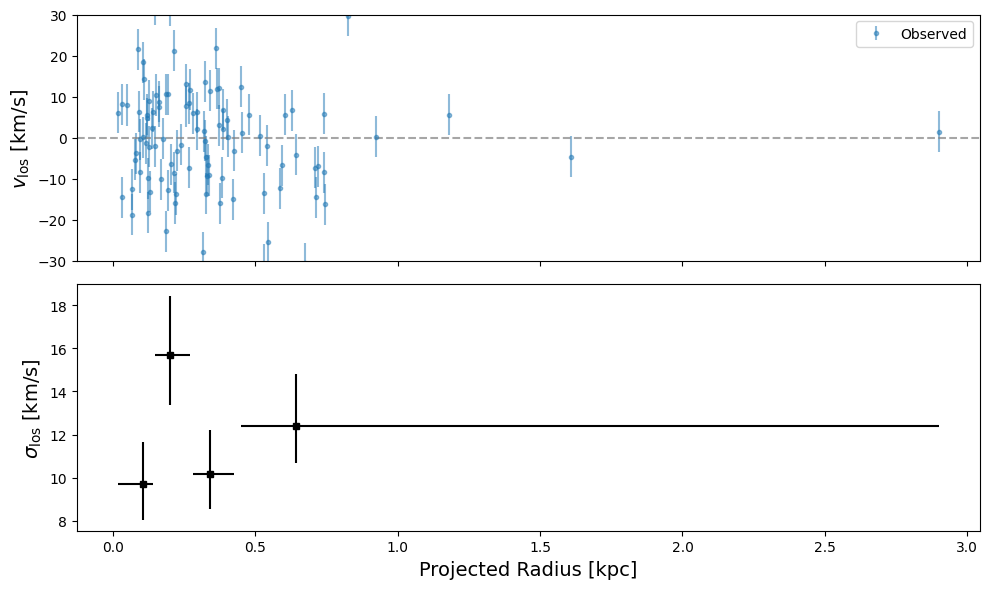

In [6]:
fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True, tight_layout=True)

axes[0].errorbar(R_proj, vlos, yerr=vlos_err, fmt='o', markersize=3, alpha=0.5, label='Observed')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.7)
axes[0].set_ylabel(r'$v_\mathrm{los}$ [km/s]', fontsize=14)
axes[0].set_ylim(-30, 30)

# plot the binned velocity dispersion
R_mid = vdisp_binned_res['R_mid']
R_em = vdisp_binned_res['R_em']
R_ep = vdisp_binned_res['R_ep']
sigma = vdisp_binned_res['sigma']
sigma_em = vdisp_binned_res['sigma_em']
sigma_ep = vdisp_binned_res['sigma_ep']
axes[1].errorbar(
    R_mid, sigma,
    yerr=[sigma_em, sigma_ep],
    xerr=[R_em, R_ep],
    fmt='s', color='black',
    markersize=4, label='Binned Dispersion')
axes[1].set_ylabel(r'$\sigma_\mathrm{los}$ [km/s]', fontsize=14)
axes[1].set_xlabel('Projected Radius [kpc]', fontsize=14)

axes[0].legend()
plt.show()

## The Generalized Osipkov-Merritt Anisotropy Profile

The generalized Osipkov-Merritt anisotropy profile is given by:

$$
\beta(r) = \beta_0 + (\beta_\infty - \beta_0) \frac{r^2}{r^2 + r_a^2}
$$

where:
- $\beta_0$ is the **central anisotropy** (at $r \to 0$)
- $\beta_\infty$ is the **outer anisotropy** (at $r \to \infty$)
- $r_a$ is the **anisotropy radius** controlling the transition

Special cases:
- Standard Osipkov-Merritt: $\beta_0 = 0$, $\beta_\infty = 1$
- Constant anisotropy: $\beta_0 = \beta_\infty$ (or $r_a \to \infty$)
- Isotropic: $\beta_0 = \beta_\infty = 0$

The corresponding $g(r)$ function in the Jeans equations is:

$$
g(r) = r^{2\beta_0} \left(1 + \frac{r^2}{r_a^2}\right)^{\beta_\infty - \beta_0}
$$

This can be derived from $g(r) = \exp\left(2\int_0^r \frac{\beta(s)}{s} ds\right)$.

## 1. Implementing the Generalized OM Jeans Model

### 1a. Implementing the anisotropy functions

Your main task in this notebook is to implement the `beta(r)` and `gbeta(r)` methods for the generalized Osipkov-Merritt profile with parameters $\beta_0$, $\beta_\infty$, and $r_a$.

For the `_sigma2_r` and `_sigma2_los_R` methods, you can **copy your implementation from the previous notebook** (`01_constant_beta.ipynb`). These methods use `self.beta(r)` and `self.gbeta(r)`, so they will automatically use the correct anisotropy profile.

In [7]:
import scipy.special as sc
from scipy.interpolate import interp1d
from scipy.integrate import quad


class GeneralizedOMJeans:
    """
    A class to model the velocity dispersion profile using the Jeans equation
    with a generalized Osipkov-Merritt anisotropy profile.

    The generalized OM profile allows arbitrary central (beta_0) and outer
    (beta_inf) anisotropy, with a transition controlled by the anisotropy
    radius r_a.
    """
    def __init__(self, theta, min_radius=1e-3, max_radius=5, n_radius=200):
        """
        Args:
            theta (list): Model parameters [log_rho_s, log_r_s, gam, rh, vsys, log_r_a, beta_0, beta_inf].
            min_radius (float, optional): Minimum radius [kpc]. Defaults to 1e-3.
            max_radius (float, optional): Maximum radius [kpc]. Defaults to 5.
            n_radius (int, optional): Number of radius points. Defaults to 200.
        """
        self.param = theta
        self.log_rho_s = self.param[0]
        self.rho_s = 10.0 ** self.param[0]
        self.log_r_s = self.param[1]
        self.r_s = 10.0 ** self.param[1]
        self.gam = self.param[2]
        self.log_r_a = self.param[3]
        self.r_a = 10.0 ** self.param[3]
        self.two_to_beta0 = self.param[4]
        self.beta0 = np.log2(self.two_to_beta0)
        self.two_to_betainf = self.param[5]
        self.betainf = np.log2(self.two_to_betainf)
        self.rh = self.param[6]
        self.vsys = self.param[7]

        self.r_vec = np.logspace(np.log10(min_radius), np.log10(max_radius), n_radius)

    def rho(self, r):
        """Dark matter density profile (generalized NFW)."""
        c1 = self.rho_s * (r / self.r_s)**(-self.gam)
        c2 = (1 + (r / self.r_s))**(-(3 - self.gam))
        return c1 * c2

    def M(self, r):
        """Enclosed dark matter mass profile."""
        r_n = r / self.r_s
        c1 = (4 * np.pi * self.rho_s * self.r_s**3) / (3.0 - self.gam)
        c2 = r_n ** (3.0 - self.gam)
        return c1 * c2 * sc.hyp2f1(
            3.0 - self.gam, 3.0 - self.gam, 1.0 + (3.0 - self.gam), -r_n)

    def nu(self, r):
        """3D stellar density profile (Plummer)."""
        return 3.0 / (4.0 * np.pi * self.rh**3) * (1 + (r / self.rh)**2)**(-2.5)

    def I(self, R):
        """Projected stellar surface density (Plummer)."""
        return 1.0 / (np.pi * self.rh**2) * (1 + (R / self.rh)**2)**(-2)

    # =========================================================================
    # TODO: Implement the two methods below (beta and gbeta) for the
    # generalized OM profile.
    #
    # Generalized Osipkov-Merritt anisotropy:
    #   beta(r) = beta_0 + (beta_inf - beta_0) * r^2 / (r^2 + r_a^2)
    #   g(r) = r^(2*beta_0) * (1 + r^2/r_a^2)^(beta_inf - beta_0)
    #
    # Use self.r_a, self.beta_0, and self.beta_inf for the parameters.
    # =========================================================================

    def beta(self, r):
        """
        Velocity anisotropy parameter for the generalized OM profile.

        TODO: Implement beta(r) = beta_0 + (beta_inf - beta_0) * r^2 / (r^2 + r_a^2)

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Velocity anisotropy parameter at radius r.
        """
        return self.beta0 + (self.betainf - self.beta0) * r**2 / (r**2 + self.r_a**2)

    def gbeta(self, r):
        """
        Compute the function g(r) for the generalized OM profile.

        TODO: Implement g(r) = r^(2*beta_0) * (1 + r^2/r_a^2)^(beta_inf - beta_0)

        Note: Be careful with r=0 when beta_0 != 0. The limit is well-defined
        but numerical evaluation requires care.

        Args:
            r (float): Radius [kpc].

        Returns:
            float: g(r) value at radius r.
        """
        return r**(2 * self.beta0) * (1 + r**2 / self.r_a**2)**(self.betainf - self.beta0)

    # =========================================================================
    # The methods below (_sigma2_r and _sigma2_los_R) are the same as in
    # 01_constant_beta.ipynb. You can copy your implementation from there.
    #
    # Note: These methods use self.beta(r) and self.gbeta(r), so they will
    # automatically use the generalized OM profile.
    # =========================================================================

    def _sigma2_r(self, r):
        """
        Compute the radial velocity dispersion squared at a single radius r.
        (Copy your implementation from 01_constant_beta.ipynb)
        """
        def integrand(s):
            return constants.G.value * self.M(s) / s**2 * self.nu(s) * self.gbeta(s)

        c1 = 1.0 / (self.nu(r) * self.gbeta(r))
        integral, _ = quad(integrand, r, np.inf, epsabs=1, epsrel=1)
        to_km2_s2 = 1.989 * 1e12 / 3.0856
        return c1 * integral * to_km2_s2

    def _sigma2_los_R(self, R, sigma2_r_fn):
        """
        Compute the line-of-sight velocity dispersion squared at projected radius R.
        (Copy your implementation from 01_constant_beta.ipynb)

        Note: Use self.beta(r) for the radius-dependent anisotropy term!
        """
        def integrand(r):
            anisotropy_term = 1 - self.beta(r) * (R / r)**2
            kernel = r / np.sqrt(r**2 - R**2)
            return anisotropy_term * self.nu(r) * sigma2_r_fn(r) * kernel

        integral, _ = quad(integrand, R, np.inf, epsabs=1, epsrel=1)
        return 2.0 / self.I(R) * integral

    # =========================================================================
    # Public methods below: these handle vectorization and interpolation.
    # You do NOT need to modify these.
    # =========================================================================

    def sigma2(self, r_vec):
        """Compute sigma_r^2 over an array of radii and return an interpolator."""
        return interp1d(
            r_vec,
            list(map(self._sigma2_r, r_vec)),
            bounds_error=False,
            fill_value=0.0,
            kind="linear",
        )

    def sigma2_los(self, min_radius=1e-3):
        """Compute the line-of-sight velocity dispersion profile."""
        r_grid = np.logspace(np.log10(min_radius), np.log10(50), 500)
        sigma2_r_fn = self.sigma2(r_grid)
        sigma2_los = np.array([
            self._sigma2_los_R(R, sigma2_r_fn) for R in self.r_vec
        ])
        return sigma2_los

In [8]:
# =============================================================================
# Test: Verify your implementation of beta and gbeta for the generalized OM
# =============================================================================
def test_generalized_om_anisotropy():
    """Test the generalized OM anisotropy functions."""

    # theta = [log_rho_s, log_r_s, gam, rh, vsys, log_r_a, beta_0, beta_inf]
    r_a = 0.5

    # ----- Test 1: Standard OM (beta_0=0, beta_inf=1) -----
    theta_std = [0.0, 0.0, 1.0, np.log10(r_a), 1.0, 2.0, 0.3, 0.0]
    model_std = GeneralizedOMJeans(theta_std)

    # At r = 0: beta should be beta_0 = 0
    assert np.isclose(model_std.beta(0.0), 0.0, atol=1e-10), \
        f"Standard OM: beta(0) got {model_std.beta(0.0)}, expected 0.0"
    # At r = r_a: beta should be (beta_0 + beta_inf)/2 = 0.5
    assert np.isclose(model_std.beta(r_a), 0.5, rtol=1e-6), \
        f"Standard OM: beta(r_a) got {model_std.beta(r_a)}, expected 0.5"
    # At r >> r_a: beta should approach beta_inf = 1
    assert model_std.beta(100 * r_a) > 0.99, \
        f"Standard OM: beta(100*r_a) failed, got {model_std.beta(100*r_a)}"

    # g(r) tests for standard OM
    assert np.isclose(model_std.gbeta(0.0), 1.0, rtol=1e-6), \
        f"Standard OM: gbeta(0) failed, got {model_std.gbeta(0.0)}, expected 1.0"
    assert np.isclose(model_std.gbeta(r_a), 2.0, rtol=1e-6), \
        f"Standard OM: gbeta(r_a) failed, got {model_std.gbeta(r_a)}, expected 2.0"

    # ----- Test 2: Generalized OM (beta_0=-0.5, beta_inf=0.8) -----
    theta_gen = [0.0, 0.0, 1.0, np.log10(r_a), 2**(-0.5), 2**0.8, 0.3, 0.0]
    model_gen = GeneralizedOMJeans(theta_gen)

    # At r = 0: beta should be beta_0 = -0.5
    assert np.isclose(model_gen.beta(0.0), -0.5, atol=1e-10), \
        f"Generalized OM: beta(0) failed: got {model_gen.beta(0.0)}"
    # At r = r_a: beta should be (beta_0 + beta_inf)/2 = 0.15
    assert np.isclose(model_gen.beta(r_a), 0.15, rtol=1e-6), \
        f"Generalized OM: beta(r_a) failed: got {model_gen.beta(r_a)}"
    # At r >> r_a: beta should approach beta_inf = 0.8
    assert np.isclose(model_gen.beta(100 * r_a), 0.8, rtol=1e-2), \
        f"Generalized OM: beta(inf) failed: got {model_gen.beta(100*r_a)}"

    # g(r) for generalized OM: g(r) = r^(2*beta_0) * (1 + r^2/r_a^2)^(beta_inf - beta_0)
    expected_g = r_a**(-1.0) * 2**(0.8 - (-0.5))
    assert np.isclose(model_gen.gbeta(r_a), expected_g, rtol=1e-6), \
        f"Generalized OM: gbeta(r_a) failed: got {model_gen.gbeta(r_a)}, expected {expected_g}"

    print("Generalized OM anisotropy tests passed!")

test_generalized_om_anisotropy()

Generalized OM anisotropy tests passed!


### Visualizing the generalized OM anisotropy profile

Let's visualize how the anisotropy profile varies for different combinations of $\beta_0$, $\beta_\infty$, and $r_a$.

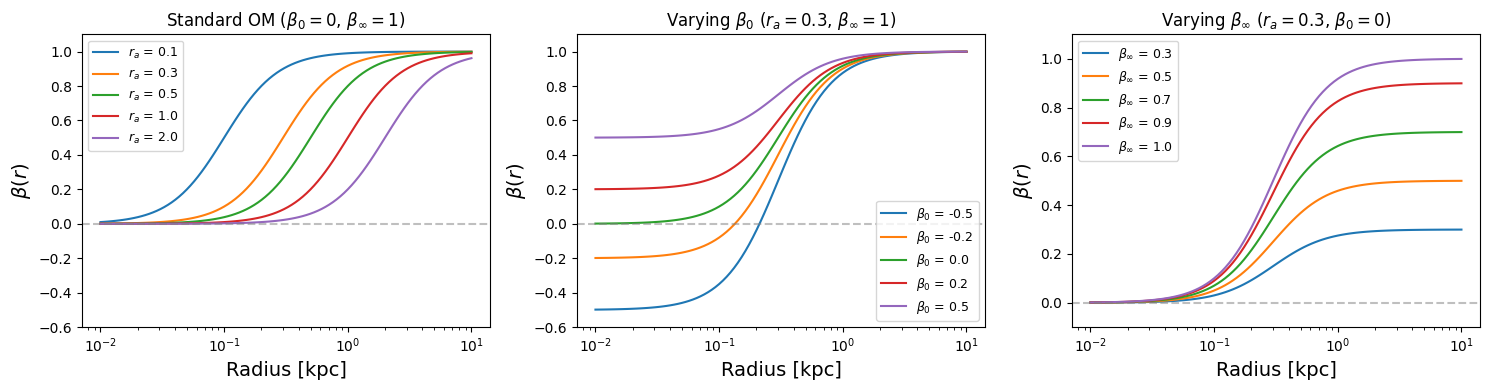

In [9]:
# theta = [log_rho_s, log_r_s, gam, rh, vsys, log_r_a, beta_0, beta_inf]
r_plot = np.logspace(-2, 1, 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

# Plot 1: Varying r_a with standard OM (beta_0=0, beta_inf=1)
ax = axes[0]
for r_a in [0.1, 0.3, 0.5, 1.0, 2.0]:
    theta = [0.0, 0.0, 1.0, np.log10(r_a), 1.0, 2.0, 0.3, 0.]
    model = GeneralizedOMJeans(theta)
    beta_vals = [model.beta(r) for r in r_plot]
    ax.plot(r_plot, beta_vals, label=f'$r_a$ = {r_a}')

ax.set_xscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\beta(r)$', fontsize=14)
ax.set_title(r'Standard OM ($\beta_0=0$, $\beta_\infty=1$)', fontsize=12)
ax.legend(fontsize=9)
ax.set_ylim(-0.6, 1.1)

# Plot 2: Varying beta_0 with fixed r_a and beta_inf
ax = axes[1]
r_a = 0.3
for beta_0 in [-0.5, -0.2, 0.0, 0.2, 0.5]:
    theta = [0.0, 0.0, 1.0, np.log10(r_a), 2**beta_0, 2.0, 0.3, 0.]
    model = GeneralizedOMJeans(theta)
    beta_vals = [model.beta(r) for r in r_plot]
    ax.plot(r_plot, beta_vals, label=f'$\\beta_0$ = {beta_0}')

ax.set_xscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\beta(r)$', fontsize=14)
ax.set_title(r'Varying $\beta_0$ ($r_a=0.3$, $\beta_\infty=1$)', fontsize=12)
ax.legend(fontsize=9)
ax.set_ylim(-0.6, 1.1)

# Plot 3: Varying beta_inf with fixed r_a and beta_0
ax = axes[2]
r_a = 0.3
for beta_inf in [0.3, 0.5, 0.7, 0.9, 1.0]:
    theta = [0.0, 0.0, 1.0, np.log10(r_a), 1.0, 2**beta_inf, 0.3, 0.0]
    model = GeneralizedOMJeans(theta)
    beta_vals = [model.beta(r) for r in r_plot]
    ax.plot(r_plot, beta_vals, label=f'$\\beta_\\infty$ = {beta_inf}')

ax.set_xscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\beta(r)$', fontsize=14)
ax.set_title(r'Varying $\beta_\infty$ ($r_a=0.3$, $\beta_0=0$)', fontsize=12)
ax.legend(fontsize=9)
ax.set_ylim(-0.1, 1.1)

# mark the isotropic line beta=0
for ax in axes:
    ax.axhline(0.0, color='gray', linestyle='--', alpha=0.5)

plt.show()

### 1b. Defining the likelihood function

The likelihood function is similar to the constant anisotropy case, but now uses the `OsipkovMerrittJeans` class with the anisotropy radius $r_a$ as a parameter.

In [10]:
from scipy.stats import uniform, norm

In [11]:
def log_likelihood_gen_om(theta, r_obs, v_obs, v_err_obs):
    """
    Compute the log likelihood for the generalized OM Jeans model.

    Args:
        theta (np.ndarray): Model parameters:
            [log_rho_s, log_r_s, gam, rh, vsys, log_r_a, beta_0, beta_inf]
        r_obs (np.ndarray): Observed projected radii [kpc].
        v_obs (np.ndarray): Observed line-of-sight velocities [km/s].
        v_err_obs (np.ndarray): Velocity measurement errors [km/s].

    Returns:
        float: Log likelihood value, or -inf if model is invalid.
    """
    model = GeneralizedOMJeans(theta)
    sigma2_los_grid = model.sigma2_los()
    sigma2_los_fn = interp1d(
        model.r_vec, sigma2_los_grid,
        bounds_error=False, fill_value=0.0, kind="linear"
    )
    sigma2_los = sigma2_los_fn(r_obs)

    # Check for invalid dispersion values
    if np.any(sigma2_los <= 0):
        return -np.inf

    # Compute total variance and log-likelihood
    sigma2_tot = sigma2_los + v_err_obs**2
    lnlike = norm.logpdf(v_obs, loc=model.vsys, scale=np.sqrt(sigma2_tot))

    if np.any(~np.isfinite(lnlike)):
        return -np.inf

    return lnlike.sum()

In [12]:
# =============================================================================
# Test: Verify your log_likelihood_gen_om implementation
# =============================================================================
def test_log_likelihood_gen_om():
    """Test the log_likelihood_gen_om function with known reference values."""

    # theta = [log_rho_s, log_r_s, gam, log_r_a, 2^beta_0, 2^beta_inf, rh, vsys]
    # Standard OM: beta_0=0, beta_inf=1
    theta_test = [0.0, 0.0, 1.0, np.log10(0.5), 1.0, 2.0, 0.3, 0.0]
    r_obs = np.array([0.1, 0.3, 0.5, 0.8, 1.0])
    v_obs = np.array([5.0, -3.0, 2.0, -1.0, 4.0])
    v_err = np.array([5.0, 5.0, 5.0, 5.0, 5.0])

    ll = log_likelihood_gen_om(theta_test, r_obs, v_obs, v_err)
    assert np.isclose(ll, -14.667455, rtol=1e-3), \
        f"log_likelihood_gen_om failed: got {ll:.6f}, expected -14.667455"

    # Generalized OM: beta_0=-0.5, beta_inf=0.8, ra=1
    theta_test_gen = [0.0, 0.0, 1.0, np.log10(1.0), 2**(-0.5), 2**0.8, 0.3, 0.0]
    ll_gen = log_likelihood_gen_om(theta_test_gen, r_obs, v_obs, v_err)
    assert np.isclose(ll_gen, -14.847385, rtol=1e-3), \
        f"log_likelihood_gen_om (generalized) failed: got {ll_gen:.6f}, expected -14.847385"

    # Generalized OM: beta_0=0.3, beta_inf=0.5, ra=0.1
    theta_test_gen2 = [0.0, 0.0, 1.0, np.log10(0.1), 2**0.3, 2**0.5, 0.3, 0.0]
    ll_gen2 = log_likelihood_gen_om(theta_test_gen2, r_obs, v_obs, v_err)
    assert np.isclose(ll_gen2, -14.698382, rtol=1e-3), \
        f"log_likelihood_gen_om (generalized 2) failed: got {ll_gen2:.6f}, expected -14.698382"

    print("All likelihood tests passed!")

test_log_likelihood_gen_om()

All likelihood tests passed!


### 1c. Fitting the OM model to data

In [13]:
import multiprocess as mp
import pocomc as pc

In [14]:
class UniformPrior():
    def __init__(self, name, low, high):
        self.name = name
        self.low = low
        self.high = high
        self.dist = uniform(loc=low, scale=high - low)

    def logpdf(self, x):
        return self.dist.logpdf(x)

    def rvs(self, size=1):
        return self.dist.rvs(size=size)

# Constructing priors for the generalized OM model
r_half_kpc = true_parameters['r_half_kpc'].values[0]
priors_gen_om = dict(
    log_rho_s=UniformPrior("log_rho_s", -3.0, 3.0),
    log_r_s=UniformPrior("log_r_s", -3.0, 3.0),
    gam=UniformPrior("gam", 0.0, 1.5),
    log_r_a=UniformPrior("log_r_a", -2.0, 2.0),
    two_to_beta0=UniformPrior("two_to_beta0", 0.0, 1.0),
    two_to_betainf=UniformPrior("two_to_betainf", 0.0, 2.0),
    rh=UniformPrior("rh", r_half_kpc - 0.1, r_half_kpc + 0.1),
    vsys=UniformPrior("vsys", -1e3, 1e3),
)

prior_list_gen_om = [
    priors_gen_om[key].dist for key in
    ["log_rho_s", "log_r_s", "gam", "log_r_a", "two_to_beta0", "two_to_betainf", "rh", "vsys"]
]

pc_priors_gen_om = pc.Prior(prior_list_gen_om)

This should take about 20-30 minutes to run.

In [15]:
# Run sampler
n_cpus = 32
n_total = 4000  # we need more samples here due to larger parameter space

print(f"\nRunning generalized OM sampler with {n_cpus} CPUs, n_total={n_total} samples...\n")

with mp.Pool(n_cpus) as pool:
    sampler_gen_om = pc.Sampler(
        prior=pc_priors_gen_om,
        likelihood=log_likelihood_gen_om,
        likelihood_kwargs=
            r_obs=R_proj,
            v_obs=vlos,
            v_err_obs=vlos_err,
        ),
        pool=pool,
        vectorize=False,
    )
    sampler_gen_om.run(n_total=n_total, progress=True)
    samples_gen_om, logl_gen_om, logp_gen_om = sampler_gen_om.posterior(resample=True)


Running generalized OM sampler with 32 CPUs, n_total=4000 samples...



Iter: 34it [09:32, 16.83s/it, beta=1, calls=56320, ESS=3903, logZ=-413, logP=-414, acc=0.449, steps=8, eff=1]         


### 1d. Analyzing the posterior

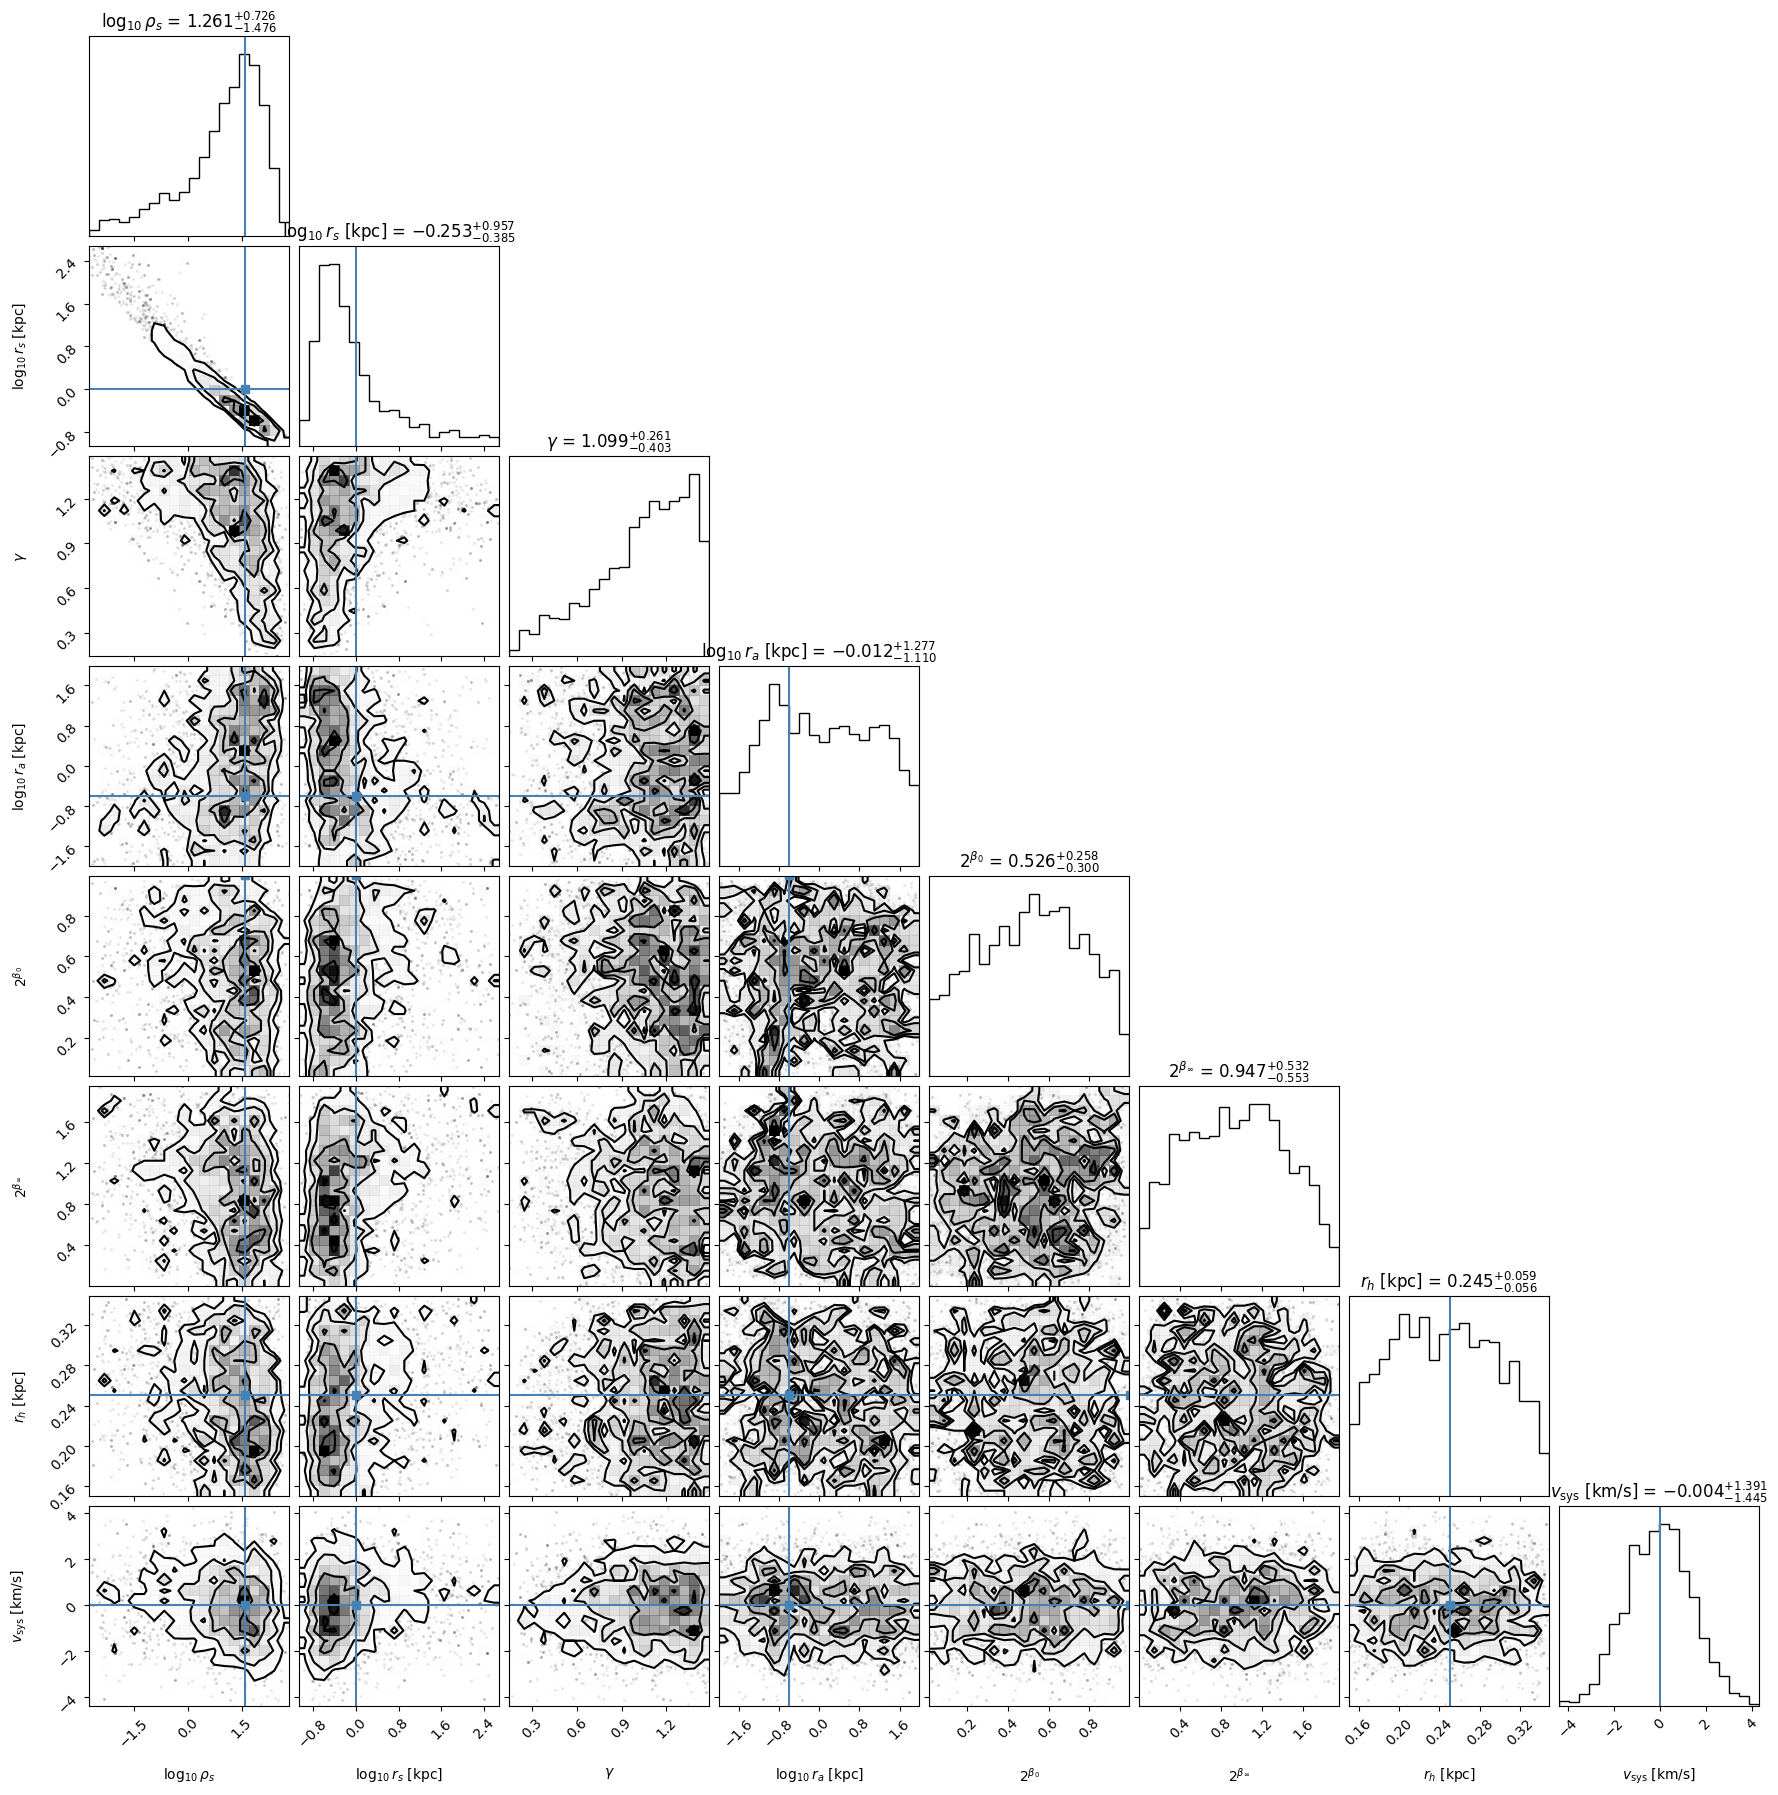

In [16]:
import corner

theta_true_gen_om = np.array([
    np.log10(true_parameters['rho_dm'].values[0]) - 7,
    np.log10(true_parameters['r_dm'].values[0]),
    true_parameters['gamma'].values[0],
    np.log10(true_parameters['r_a_kpc'].values[0]),
    1.,  # beta_0 = 0 for Osipkov-Merritt
    2.,  # beta_inf = 1 for Osipkov-Merritt
    true_parameters['r_half_kpc'].values[0],
    0,  # vsys
])

fig = corner.corner(
    samples_gen_om,
    labels=[
        r"$\log_{10} \rho_s$",
        r"$\log_{10} r_s$ [kpc]",
        r"$\gamma$",
        r"$\log_{10} r_a$ [kpc]",
        r"$2^{\beta_0}$",
        r"$2^{\beta_\infty}$",
        r"$r_h$ [kpc]",
        r"$v_\mathrm{sys}$ [km/s]",
    ],
    truths=theta_true_gen_om,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
)

In [17]:
# Compute posterior profiles
r_plot = np.logspace(-2, 2, 50)
num_max_samples = 500
samples_choice_gen_om = np.random.choice(
    samples_gen_om.shape[0], size=num_max_samples, replace=False)

rho_dm_samples_gen_om = np.zeros((num_max_samples, len(r_plot)))
mass_dm_samples_gen_om = np.zeros((num_max_samples, len(r_plot)))
vdisp_samples_gen_om = np.zeros((num_max_samples, len(r_plot)))
beta_samples_gen_om = np.zeros((num_max_samples, len(r_plot)))

for i, theta_sample in enumerate(samples_gen_om[samples_choice_gen_om]):
    model = GeneralizedOMJeans(theta_sample, min_radius=0.01, max_radius=100, n_radius=50)
    rho_dm_samples_gen_om[i] = model.rho(r_plot)
    mass_dm_samples_gen_om[i] = model.M(r_plot)
    vdisp_samples_gen_om[i] = np.sqrt(model.sigma2_los())
    beta_samples_gen_om[i] = [model.beta(r) for r in r_plot]

# True profiles
true_model_gen_om = GeneralizedOMJeans(theta_true_gen_om, min_radius=0.01, max_radius=100, n_radius=50)
rho_dm_true_gen_om = true_model_gen_om.rho(r_plot)
mass_dm_true_gen_om = true_model_gen_om.M(r_plot)
vdisp_true_gen_om = np.sqrt(true_model_gen_om.sigma2_los())
beta_true_gen_om = [true_model_gen_om.beta(r) for r in r_plot]

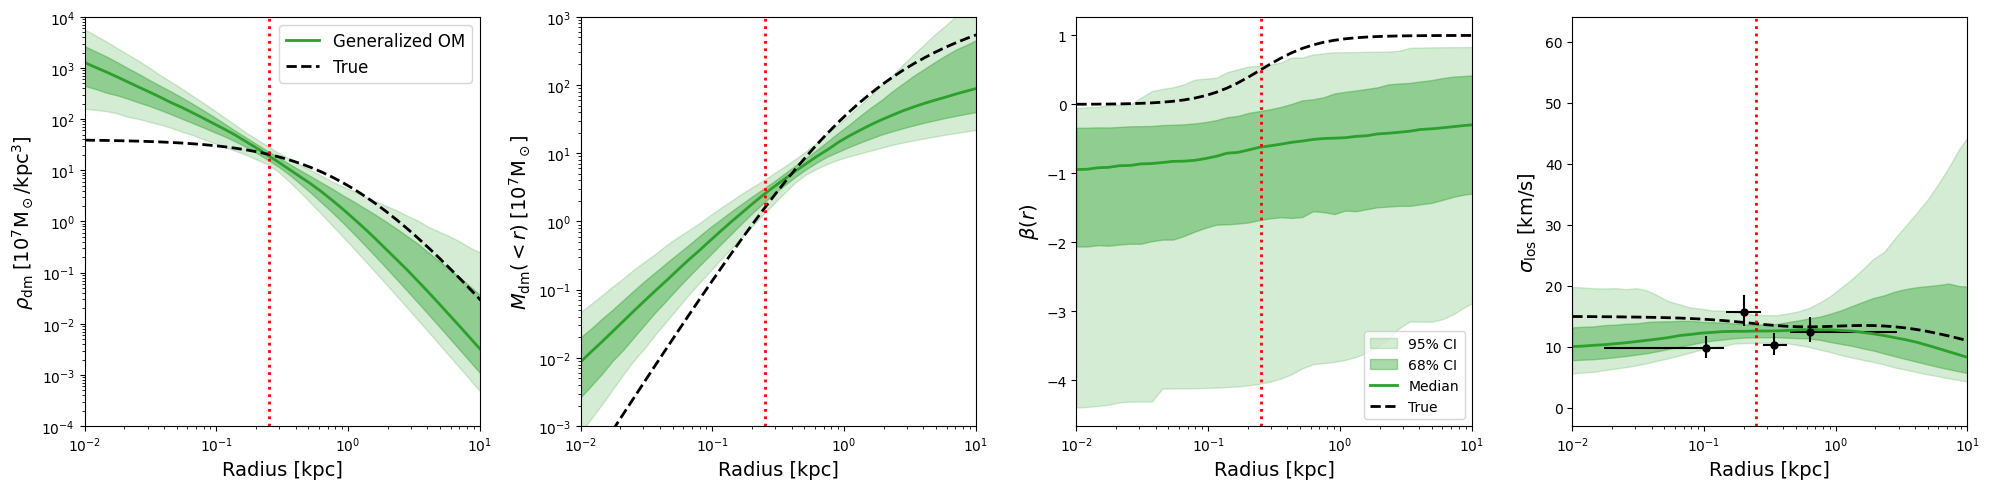

In [18]:
percentiles = [2, 16, 50, 84, 98]

fig, axes = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)

# ---- Dark Matter Density Profile ----
ax = axes[0]
rho_dm_q = np.percentile(rho_dm_samples_gen_om, percentiles, axis=0)
ax.fill_between(r_plot, rho_dm_q[0], rho_dm_q[4], color='C2', alpha=0.2)
ax.fill_between(r_plot, rho_dm_q[1], rho_dm_q[3], color='C2', alpha=0.4)
ax.plot(r_plot, rho_dm_q[2], color='C2', linestyle='-', lw=2, label='Generalized OM')
ax.plot(r_plot, rho_dm_true_gen_om, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_xlim(0.01, 10)
ax.set_ylim(1e-4, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\rho_\mathrm{dm} \; [10^7 \mathrm{M_\odot/kpc^3}]$', fontsize=14)
ax.legend(fontsize=12)

# ---- Enclosed Mass Profile ----
ax = axes[1]
mass_dm_q = np.percentile(mass_dm_samples_gen_om, percentiles, axis=0)
ax.fill_between(r_plot, mass_dm_q[0], mass_dm_q[4], color='C2', alpha=0.2)
ax.fill_between(r_plot, mass_dm_q[1], mass_dm_q[3], color='C2', alpha=0.4)
ax.plot(r_plot, mass_dm_q[2], color='C2', linestyle='-', lw=2, label='Generalized OM')
ax.plot(r_plot, mass_dm_true_gen_om, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_xlim(0.01, 10)
ax.set_ylim(1e-3, 1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$M_\mathrm{dm}(<r) \; [10^7 \mathrm{M_\odot}]$', fontsize=14)

# ---- Beta Profile ----
ax = axes[2]
beta_q = np.percentile(beta_samples_gen_om, percentiles, axis=0)
ax.fill_between(r_plot, beta_q[0], beta_q[4], color='C2', alpha=0.2, label='95% CI')
ax.fill_between(r_plot, beta_q[1], beta_q[3], color='C2', alpha=0.4, label='68% CI')
ax.plot(r_plot, beta_q[2], color='C2', linestyle='-', lw=2, label='Median')
ax.plot(r_plot, beta_true_gen_om, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_xlim(0.01, 10)
ax.set_xscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\beta(r)$', fontsize=14)
ax.legend(fontsize=10)

# ---- Velocity Dispersion Profile ----
ax = axes[3]
ax.errorbar(
    R_mid, sigma,
    yerr=[sigma_em, sigma_ep],
    xerr=[R_em, R_ep],
    fmt='o', color='black',
    markersize=5, label='Binned Data'
)
vdisp_q = np.percentile(vdisp_samples_gen_om, percentiles, axis=0)
ax.fill_between(r_plot, vdisp_q[0], vdisp_q[4], color='C2', alpha=0.2)
ax.fill_between(r_plot, vdisp_q[1], vdisp_q[3], color='C2', alpha=0.4)
ax.plot(r_plot, vdisp_q[2], color='C2', linestyle='-', lw=2, label='Generalized OM')
ax.plot(r_plot, vdisp_true_gen_om, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_xlim(0.01, 10)
ax.set_xscale('log')
ax.set_xlabel('Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\sigma_\mathrm{los}$ [km/s]', fontsize=14)

plt.show()

Observe how both the anisotropy parameters and mass parameters are completely offed compared to the true values, despite the good fit to the velocity dispersion profile. This is a manifestation of the mass-anisotropy degeneracy.

## Summary
In this tutorial, we implemented Jeans modeling with the generalized Osipkov-Merritt anisotropy profile to estimate the mass distribution of a spherical stellar system. We defined a likelihood function based on observed line-of-sight velocities and used MCMC sampling to explore the posterior distributions of the model parameters, including the anisotropy parameters $\beta_0$, $\beta_\infty$, and $r_a$.